In [21]:
import sys
sys.path.append('../bayesopt')

import read_agg_data
import torch
import torch.nn as nn
import torch.autograd as auto
import torch.optim as optim

import numpy as np
import matplotlib.pylab as plt
import pandas as pd

import pdb
import math

dvfs_dict = {
    "0xC00" :  1.2,
    "0xD00" :  1.3,
    "0xE00" :  1.4,
    "0xF00" :  1.5,
    "0x1000" : 1.6,
    "0x1100" : 1.7,
    "0x1200" : 1.8,
    "0x1300" : 1.9,
    "0x1400" : 2.0,
    "0x1500" : 2.1,
    "0x1600" : 2.2,
    "0x1700" : 2.3,
    "0x1800" : 2.4,
    "0x1900" : 2.5,
    "0x1A00" : 2.6,
    "0x1B00" : 2.7,
    "0x1C00" : 2.8,
    "0x1D00" : 2.9,
    "0xffff" : 3.0,
}

JOULE_CONVERSION = 0.00001526 #counter * constant -> JoulesOB
TIME_CONVERSION_khz = 1./(2899999*1000)


In [32]:
#df_comb, _, _ = read_agg_data.start_analysis('mcd') #DATA
#df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: int(x, base=16))

df_comb = pd.read_csv('/home/handong/jupyter/jupyter-notebooks/nic-tuning-experiments/bayesopt/summary_data/ebbrt_netpipe_old.csv', sep=' ')
df_comb['joules'] = df_comb['PK1_JOULE']
df_comb['time'] = (df_comb['END_RDTSC']* TIME_CONVERSION_khz) - (df_comb['START_RDTSC']* TIME_CONVERSION_khz)
df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: dvfs_dict[x])
df_comb = df_comb[(df_comb['rapl'] == 135)]
df_comb = df_comb[(df_comb['itr']!=1) & (df_comb['dvfs']!=65535)] #filter out linux dynamic
df_comb['sys'] = 'ebbrt_tuned'

print(df_comb['itr'].unique())
print(df_comb['msg'].unique())
print(df_comb.columns)


df = df_comb[['joules', 'msg', 'itr', 'dvfs', 'time']]
for itr in [6, 8, 12, 16, 20, 24, 28]:
    for msg in [8192]:
        dfi = df[(df['itr']==itr) & (df['msg']==msg)]
        print('*******', itr, msg)
        print(dfi.sort_values(by=['dvfs']))
            
#print(df.sort_values(by=['dvfs']))

# df_comb = df_comb[(df_comb['i'] == 1) & (df_comb['rapl'] == 135)]
#df_comb = df_comb[(df_comb['rapl'] == 135)]

# df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: dvfs_dict[x])
# 

# print(df_comb['time'].min())
# print(df_comb.columns)
# print(df_comb['itr'].unique())
# print(df_comb['dvfs'].unique())
# print(df_comb['msg'].unique())
# print(df_comb['sys'].unique())
# print(df_comb.shape[0])

# df_comb['dvfs'] = df_comb['dvfs'].astype(float) / df_comb['dvfs'].min()
# print(df_comb['dvfs'].unique())
# df_comb['itr'] = df_comb['itr'].astype(float) / df_comb['itr'].min()
# print(df_comb['itr'].unique())
#print(10**6)

print(df_comb.columns)


[  6   8  12  16  20  24  28  32  36  40  60  80 100]
[    64   8192  65536 524288]
Index(['itr', 'msg', 'dvfs', 'rapl', 'tput', 'lat', 'PK0_JOULE', 'PK1_JOULE',
       'START_RDTSC', 'END_RDTSC', 'joules', 'time', 'sys'],
      dtype='object')
******* 6 8192
        joules   msg  itr  dvfs      time
2649  4.370693  8192    6   1.2  0.232333
2493  4.542444  8192    6   1.3  0.238059
2337  5.119379  8192    6   1.4  0.261364
2181  5.309122  8192    6   1.5  0.263917
2025  5.169234  8192    6   1.6  0.250664
1869  4.218078  8192    6   1.7  0.219205
1713  4.262027  8192    6   1.8  0.220848
1557  4.382398  8192    6   1.9  0.220543
1401  4.432221  8192    6   2.0  0.222492
1245  4.419250  8192    6   2.1  0.223286
1089  4.418564  8192    6   2.2  0.223600
933   4.454364  8192    6   2.3  0.224988
781   4.380780  8192    6   2.4  0.223695
625   4.451052  8192    6   2.5  0.226300
469   4.359157  8192    6   2.6  0.224094
313   4.296392  8192    6   2.7  0.224996
157   4.387677  8192    6 

In [29]:
def inference_time(d, n_iter, lr, workload, sys, print_freq=10):    
    #starts randomly
    max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
    alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
    #beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
    gamma = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
    delta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
    
    itr = d[:,1]
    dvfs = d[:,2]
    time = (d[:,3]/5000)
    msgsize = d[:,4]
        
    criterion = nn.MSELoss()
    optimizer_time = optim.Adam([max_time, alpha, gamma, delta], lr=lr)

    for i in range(n_iter):        
        t_busy = (torch.exp(max_time) / dvfs**(1+alpha)) ## dvfs impact on processing
        
        #pred_time = itr_suppress*itr + t_busy
        #pred_time = ((2*((itr*itr_suppress)**beta))/(10**6)) + (gamma*(2*((msgsize*8)/(10**10)))) + (2*t_busy)
        #pred_time = (gamma*itr*itr_suppress)*(dvfs**beta)
        #pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy)                
        
        #pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy) + (2*((msgsize*8)/(10**10)))
        beta = gamma*dvfs+delta
        pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy) + (2*((msgsize*8)/(10**10)))
        
        #pred_time = A(itr)**beta*(dvfs**gamma)
        #pred_time = 2*itr**(alpha*dvfs)
        
        #import pdb
        #pdb.set_trace()
        
        #loss_time = criterion(pred_time/time, torch.ones((1,pred_time.shape[1])).double())
        loss_time = criterion(pred_time, time)
        
        if i % 1000 == 0:
            print(f'MSE_loss_time={loss_time.item()} loss_time={round(math.sqrt(loss_time.item())*10**6, 5)} us '
                 + f'max_time={max_time.item()} alpha={alpha.item()} gamma={gamma.item()} delta={delta.item()}')
            
        optimizer_time.zero_grad()
        loss_time.backward()
        optimizer_time.step()


    return pred_time

In [48]:
def inference_energy(d, n_iter, lr, workload, sys, print_freq=10):
    #starts randomly
    #max_time = torch.tensor(torch.Tensor(1,1).uniform_(-5, 5), requires_grad=True)
    alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    #gamma = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    #delta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    
    energy = (d[:,0]/5000) #(d[:,0]/ninterrupts).log() ## joules/num_interrupts
    itr = d[:,1]
    dvfs = d[:,2]
    time = (d[:,3]/5000)
    msgsize = d[:,4]
        
    criterion = nn.MSELoss()
    optimizer_energy = optim.Adam([alpha, beta], lr=lr)
            
    for i in range(n_iter):
        #p_busy = (p_q*dvfs**(2+beta))
        #t_busy_energy = (max_time / dvfs**(1+beta))
        #t_q_energy = itr#(fixed_itr_suppress*itr)
        #t_q_energy = (interarrival_time - (fixed_itr_suppress*itr) - t_busy_energy)
        
        #pred_energy = (p_q * t_q_energy) + (p_busy * t_busy_energy)
        #pred_energy = AA*(fixed_itr_suppress*itr)**gamma + BB*dvfs**beta
        #loss_energy = criterion(pred_energy/energy, torch.ones((1,pred_energy.shape[1])).double())
        #pred_energy =  ((fixed_itr_suppress*itr*p_q)*((20*(10**6))/(fixed_itr_suppress*itr))) + (dvfs*beta)
        #pred_energy = ((alpha*(itr**gamma))*(delta*(dvfs**beta))) #+ (AA*(dvfs**beta))
        
        pred_energy = (alpha*itr*((msgsize*8)/(10**10)))+(dvfs*beta)
        #pred_energy = alpha*(itr+dvfs)
        #pred_energy = alpha+np.log(itr)+np.log(dvfs)
        
        #pred_energy = (gamma*(fixed_itr_suppress*itr))*(dvfs**beta) #+ (AA*(dvfs**beta))        
        #pred_energy = 2*(gamma+(np.log(itr)))+(2*(beta*np.log(dvfs)))
        
        loss_energy = criterion(pred_energy, energy)

        if i % 1000 == 0:
            print(f'MSE_loss_energy={loss_energy.item()} alpha={alpha.item()} beta={beta.item()}')
            
        optimizer_energy.zero_grad()
        loss_energy.backward(retain_graph=True)
        optimizer_energy.step()
    return pred_energy

In [33]:
def run(df_comb, n_iter=2000, lr=1, rmsg=64, msys=['ebbrt_tuned'], mpred=['energy', 'time']):       
    df_comb = df_comb[df_comb['msg'] == rmsg]

    for sys in msys:
        df = df_comb[(df_comb['sys']==sys)].copy()
        #df = df[['joules','itr', 'dvfs', 'QPS', 'read_99th', 'num_interrupts']]
        print(df['itr'].unique())
        df = df[['joules', 'itr', 'dvfs', 'time', 'msg']]
        
        tnum = df.shape[0]
        d = df.values
        d = torch.tensor(d)
        print('SYS', sys)
        
        #pred_energy, max_time, alpha, beta, p_detect, p_q = inference_energy(d, n_iter, lr, 'mcd', sys, print_freq=1000)
        #pred_energy, pred_time = inference(d, n_iter, lr, 'netpipe', sys, print_freq=1000)
        for pred_name in mpred:
            if pred_name == 'energy':
                pred_energy = inference_energy(d, n_iter, lr, 'netpipe', sys, print_freq=1000)
                pred = pred_energy
                #yvalue = (d[:,0]/d[:,4]).log()
                yvalue = (d[:,0]/5000)
                #yvalue = d[:,0]
            else:
                pred_time = inference_time(d, n_iter, lr, 'netpipe', sys, print_freq=1000)
                pred = pred_time
                yvalue = d[:,3]/5000

            fig, ax = plt.subplots()
            plt.title(f'pred:{pred_name} mcd sys={sys} lr={lr} \n MSG={rmsg}')
            #plt.title(f'pred:{pred_name} mcd sys={sys} lr={lr} tail={rtail} \n QPS={rqps} max_time={round(max_time,2)} \n alpha={round(alpha,2)} beta={round(beta.item(),2)} \n p_detect={round(p_detect.item(),2)}')
            plt.xlabel(u"predictions")
            plt.ylabel(f'{pred_name}')
            print('yvalue', yvalue.shape)
            
            
            #if pred_name == 'time':
            tmax = yvalue.max().item()
            plt.plot(np.linspace(0, tmax, 10), np.linspace(0, tmax, 10))
            
            scatter = ax.scatter(pred.detach().numpy(), yvalue, marker = 'o', 
                                 s = d[:,1], c = d[:,2], alpha=0.3)
            #scatter = ax.scatter(pred.detach().numpy(), yvalue, marker = 'o', alpha=0.3)
            plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
            plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
                        
            legend1 = ax.legend(*scatter.legend_elements(),loc="upper left", title="dvfs")
            ax.add_artist(legend1)
            handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
            legend2 = plt.legend(handles, labels, loc="lower right", title="itr")
            ax.add_artist(legend2)

[  6   8  12  16  20  24  28  32  36  40  60  80 100]
SYS ebbrt_tuned
MSE_loss_energy=5.168452341132003 alpha=-1.708956241607666 beta=1.078780174255371


<ipython-input-48-8a79515eddfe>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-48-8a79515eddfe>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([233])) that is different to the input size (torch.Size([1, 233])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE_loss_energy=3.601953520378848e-07 alpha=0.22872960567474365 beta=0.0013634448405355215
MSE_loss_energy=3.601894864483013e-07 alpha=0.23033452033996582 beta=0.0013620688114315271
MSE_loss_energy=9.201323573500481e-07 alpha=0.23068849742412567 beta=0.001715848920866847
MSE_loss_energy=5.721064796726022e-07 alpha=0.2301170527935028 beta=0.0011444255942478776
MSE_loss_energy=3.6020374264592136e-07 alpha=0.23033663630485535 beta=0.0013638535747304559
MSE_loss_energy=3.6018948767386886e-07 alpha=0.2303348183631897 beta=0.0013620519312098622
MSE_loss_energy=3.601894871860436e-07 alpha=0.2303348034620285 beta=0.0013620556565001607
yvalue torch.Size([233])


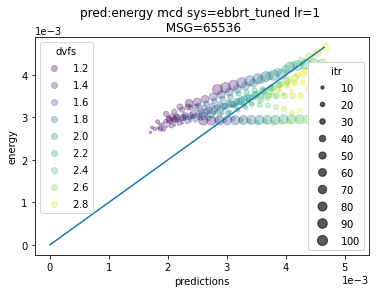

In [49]:
run(df_comb, n_iter=8000, lr=1, rmsg=65536, mpred=['energy'], msys=['ebbrt_tuned'])

[  6   8  12  16  20  24  28  32  36  40  60  80 100]
SYS ebbrt_tuned
MSE_loss_time=1.8762807855597806e-09 loss_time=43.31606 us max_time=-11.823007583618164 alpha=0.6161473989486694 gamma=0.19456696510314941 delta=0.12956058979034424


<ipython-input-29-8b1d69d90ff0>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-29-8b1d69d90ff0>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-29-8b1d69d90ff0>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-29-8b1d69d90ff0>:7: UserWarning: To copy construct f

MSE_loss_time=6.975892937025525e-11 loss_time=8.35218 us max_time=-10.534247398376465 alpha=-0.48536813259124756 gamma=0.0714179053902626 delta=0.5456116199493408
MSE_loss_time=6.318177332257112e-11 loss_time=7.9487 us max_time=-10.662113189697266 alpha=-0.6914904713630676 gamma=0.04345206543803215 delta=0.6028088927268982
MSE_loss_time=6.124368005504947e-11 loss_time=7.82583 us max_time=-10.736156463623047 alpha=-0.7997615933418274 gamma=0.026221372187137604 delta=0.6396529078483582
MSE_loss_time=6.0595445851343e-11 loss_time=7.78431 us max_time=-10.779688835144043 alpha=-0.862259566783905 gamma=0.016334425657987595 delta=0.6607226133346558
MSE_loss_time=6.036541486460858e-11 loss_time=7.76952 us max_time=-10.80585765838623 alpha=-0.8994534611701965 gamma=0.010489935986697674 delta=0.6731500029563904
MSE_loss_time=6.028115501681533e-11 loss_time=7.76409 us max_time=-10.821769714355469 alpha=-0.9219419360160828 gamma=0.006973694544285536 delta=0.6806159019470215
MSE_loss_time=6.0249726

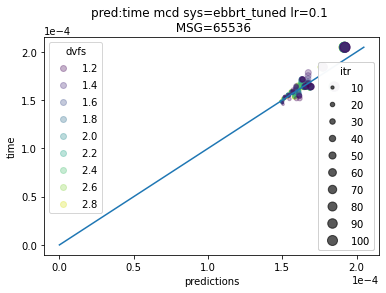

In [40]:
run(df_comb, n_iter=10000, lr=.1, rmsg=65536, mpred=['time'], msys=['ebbrt_tuned'])

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_energy=10.401746502436177 alpha=0.26566147804260254 beta=1.5014312267303467


<ipython-input-143-ef625c4b722f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-143-ef625c4b722f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([340])) that is different to the input size (torch.Size([1, 340])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE_loss_energy=3.262613680156139e-07 alpha=-1.1357345581054688 beta=0.0009362245909869671
MSE_loss_energy=3.0685046480679154e-07 alpha=-0.9034810662269592 beta=0.0009217746555805206
MSE_loss_energy=2.754881005294182e-07 alpha=-0.5081182718276978 beta=0.0008971766801550984
MSE_loss_energy=2.3110499279456789e-07 alpha=0.10404948145151138 beta=0.0008590901270508766
MSE_loss_energy=1.7641721148758873e-07 alpha=0.9801543951034546 beta=0.0008045823778957129
MSE_loss_energy=1.2128311679971452e-07 alpha=2.108976125717163 beta=0.0007343515753746033
MSE_loss_energy=8.071682083613856e-08 alpha=3.3447418212890625 beta=0.0006574671133421361
MSE_loss_energy=6.308644321431112e-08 alpha=4.339838027954102 beta=0.0005955544183962047
MSE_loss_energy=6.190181196842276e-08 alpha=4.802731990814209 beta=0.0005897650262340903
yvalue torch.Size([340])


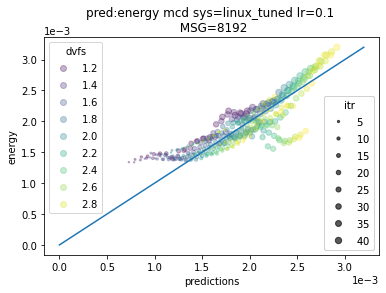

In [147]:
run(df_comb, n_iter=10000, lr=.1, rmsg=8192, mpred=['energy'], msys=['linux_tuned'])

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_time=4.697942430351674e-09 loss_time=68.54154 us max_time=-10.81550121307373 alpha=0.755046010017395 gamma=0.5304393768310547 delta=-0.1696922779083252


<ipython-input-68-4127e2a15255>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-68-4127e2a15255>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-68-4127e2a15255>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-68-4127e2a15255>:7: UserWarning: To copy construct f

MSE_loss_time=1.650716033856304e-10 loss_time=12.84802 us max_time=-9.71119213104248 alpha=-0.10054003447294235 gamma=0.0830567255616188 delta=0.8295048475265503
MSE_loss_time=1.6479061136481811e-10 loss_time=12.83708 us max_time=-9.7344331741333 alpha=-0.1372804492712021 gamma=0.07618862390518188 delta=0.8443202376365662
MSE_loss_time=1.6478467414845924e-10 loss_time=12.83685 us max_time=-9.737837791442871 alpha=-0.14262999594211578 gamma=0.07518447935581207 delta=0.8464860320091248
MSE_loss_time=1.6478453963215062e-10 loss_time=12.83684 us max_time=-9.738335609436035 alpha=-0.14341333508491516 gamma=0.0750381276011467 delta=0.8468016386032104
MSE_loss_time=1.6478453681808504e-10 loss_time=12.83684 us max_time=-9.738377571105957 alpha=-0.14348241686820984 gamma=0.07502569258213043 delta=0.8468275666236877
MSE_loss_time=1.6478453677116028e-10 loss_time=12.83684 us max_time=-9.738378524780273 alpha=-0.14348465204238892 gamma=0.07502537220716476 delta=0.8468281626701355
MSE_loss_time=1.6

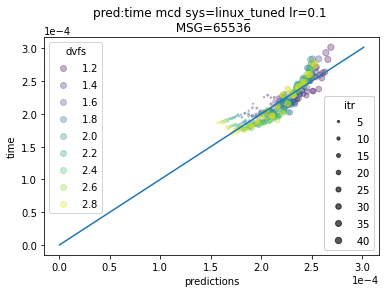

In [149]:
run(df_comb, n_iter=10000, lr=.1, rmsg=65536, mpred=['time'], msys=['linux_tuned'])


[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_energy=3.1736209974731158 alpha=1.6539652347564697 beta=-0.8273105621337891


<ipython-input-143-ef625c4b722f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-143-ef625c4b722f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([340])) that is different to the input size (torch.Size([1, 340])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE_loss_energy=8.609881749776227e-07 alpha=2.1432385444641113 beta=0.0013114969478920102
MSE_loss_energy=4.824321421179702e-07 alpha=1.61918044090271 beta=0.001572378329001367
MSE_loss_energy=3.5453072235186565e-07 alpha=1.2246168851852417 beta=0.0017687961226329207
MSE_loss_energy=3.4125223926614626e-07 alpha=1.071757197380066 beta=0.0018448913469910622
MSE_loss_energy=3.4100761104064225e-07 alpha=1.0487926006317139 beta=0.0018563230987638235
MSE_loss_energy=3.410073301453634e-07 alpha=1.047995924949646 beta=0.0018567200750112534
MSE_loss_energy=1.2136040151154726e-06 alpha=1.048421859741211 beta=0.002291131531819701
MSE_loss_energy=3.410102254985726e-07 alpha=1.0479880571365356 beta=0.001857515424489975
MSE_loss_energy=3.410073301154088e-07 alpha=1.047987937927246 beta=0.0018567241495475173
yvalue torch.Size([340])


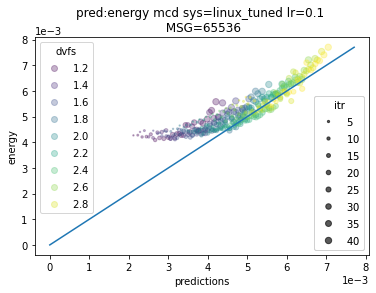

In [146]:
run(df_comb, n_iter=10000, lr=.1, rmsg=65536, mpred=['energy'], msys=['linux_tuned'])


[28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_energy=5.199010363610722 alpha=1.655785083770752 beta=-1.607767105102539


<ipython-input-143-ef625c4b722f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-143-ef625c4b722f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([1, 29])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE_loss_energy=3.3289138809710734e-05 alpha=2.7812421321868896 beta=-0.013115008361637592
MSE_loss_energy=1.4360415481617989e-05 alpha=1.9579185247421265 beta=-0.0049598123878240585
MSE_loss_energy=3.8635257924247674e-06 alpha=1.1497951745986938 beta=0.003044822718948126
MSE_loss_energy=1.4008444447896256e-06 alpha=0.6610794067382812 beta=0.00788565631955862
MSE_loss_energy=1.232328208547477e-06 alpha=0.5111297965049744 beta=0.009370938874781132
MSE_loss_energy=1.2306223463538695e-06 alpha=0.49479347467422485 beta=0.009532756172120571
MSE_loss_energy=1.2306216016418088e-06 alpha=0.4944464862346649 beta=0.009536191821098328
MSE_loss_energy=1.2306216417763603e-06 alpha=0.49444490671157837 beta=0.009536066092550755
MSE_loss_energy=1.2306610980935978e-06 alpha=0.49444931745529175 beta=0.009540589526295662
yvalue torch.Size([29])


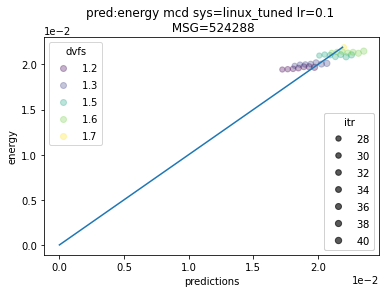

In [148]:
run(df_comb, n_iter=10000, lr=.1, rmsg=524288, mpred=['energy'], msys=['linux_tuned'])


[ 6  8 10 12 16 20 24 28]
SYS ebbrt_tuned
MSE_loss_time=9.3518833865048e-10 loss_time=30.58085 us max_time=-10.931262969970703 alpha=0.8639646768569946 gamma=-0.49780237674713135 delta=-0.21662914752960205


<ipython-input-68-4127e2a15255>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-68-4127e2a15255>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-68-4127e2a15255>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-68-4127e2a15255>:7: UserWarning: To copy construct f

MSE_loss_time=4.7445300777785e-11 loss_time=6.88805 us max_time=-10.515900611877441 alpha=-0.5818349123001099 gamma=-0.4936071038246155 delta=-0.2227908968925476
MSE_loss_time=4.236176593303981e-11 loss_time=6.50859 us max_time=-10.630703926086426 alpha=-0.748201847076416 gamma=-0.5089138746261597 delta=-0.23197980225086212
MSE_loss_time=4.217741654004542e-11 loss_time=6.49441 us max_time=-10.652167320251465 alpha=-0.7784810662269592 gamma=-0.5206874012947083 delta=-0.2379435896873474
MSE_loss_time=4.21571846459416e-11 loss_time=6.49286 us max_time=-10.65610408782959 alpha=-0.7841393947601318 gamma=-0.531475305557251 delta=-0.24318993091583252
MSE_loss_time=4.2143893041436884e-11 loss_time=6.49183 us max_time=-10.656660079956055 alpha=-0.7850796580314636 gamma=-0.5417852997779846 delta=-0.2481829822063446
MSE_loss_time=4.2131668979084197e-11 loss_time=6.49089 us max_time=-10.656660079956055 alpha=-0.7851954102516174 gamma=-0.5517299771308899 delta=-0.25301480293273926
MSE_loss_time=4.2

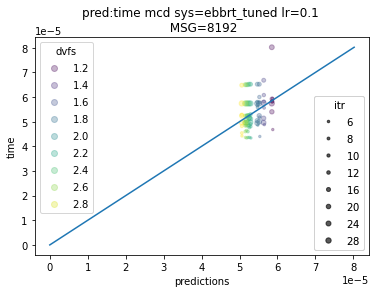

In [155]:
run(df_comb, n_iter=10000, lr=.1, rmsg=8192, mpred=['time'], msys=['ebbrt_tuned'])

[ 6  8 10 12 14 16 20 24 28 30]
SYS ebbrt_tuned
MSE_loss_energy=1.8716230579680093 alpha=-0.8316636085510254 beta=0.874535083770752


<ipython-input-143-ef625c4b722f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-143-ef625c4b722f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([49])) that is different to the input size (torch.Size([1, 49])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE_loss_energy=6.246585413241833e-07 alpha=-1.3500171899795532 beta=0.0026435942854732275
MSE_loss_energy=2.92997325904283e-07 alpha=-0.7278295755386353 beta=0.002298724604770541
MSE_loss_energy=1.1255511871187007e-07 alpha=-0.123292937874794 beta=0.001963638933375478
MSE_loss_energy=7.152672242858627e-08 alpha=0.2361350953578949 beta=0.001764413551427424
MSE_loss_energy=6.885477372127496e-08 alpha=0.34346234798431396 beta=0.0017049235757440329
MSE_loss_energy=6.88297931080648e-08 alpha=0.35467055439949036 beta=0.0016987109556794167
MSE_loss_energy=6.882978363556487e-08 alpha=0.3548932373523712 beta=0.001698593609035015
MSE_loss_energy=4.516908398239483e-07 alpha=0.35528793931007385 beta=0.0020928415469825268
MSE_loss_energy=6.883143400136191e-08 alpha=0.35489335656166077 beta=0.0016977684572339058
MSE_loss_energy=6.882978354508891e-08 alpha=0.3548942506313324 beta=0.001698586973361671
MSE_loss_energy=3.676757241138263e-05 alpha=0.35874953866004944 beta=0.005558536853641272
MSE_loss_e

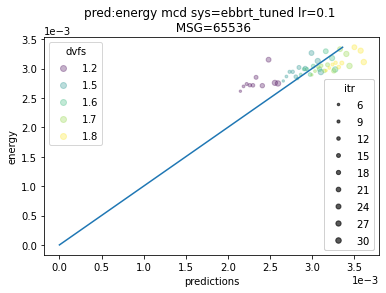

In [159]:
run(df_comb, n_iter=15000, lr=.1, rmsg=65536, mpred=['energy'], msys=['ebbrt_tuned'])

[ 6  8 10 12 14 16 20 24 28 30]
SYS ebbrt_tuned
MSE_loss_time=6.258170179356339e-10 loss_time=25.01634 us max_time=-11.112141609191895 alpha=-0.20667457580566406 gamma=0.20616579055786133 delta=0.14654159545898438


<ipython-input-68-4127e2a15255>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-68-4127e2a15255>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-68-4127e2a15255>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-68-4127e2a15255>:7: UserWarning: To copy construct f

MSE_loss_time=3.8352846966180634e-11 loss_time=6.19297 us max_time=-10.703995704650879 alpha=-0.4967239797115326 gamma=0.32468709349632263 delta=0.23750276863574982
MSE_loss_time=3.739892863921175e-11 loss_time=6.11547 us max_time=-10.730485916137695 alpha=-0.5888569355010986 gamma=0.3261134624481201 delta=0.22593876719474792
MSE_loss_time=3.6967499875839745e-11 loss_time=6.08009 us max_time=-10.750848770141602 alpha=-0.6498305797576904 gamma=0.3184581995010376 delta=0.23383992910385132
MSE_loss_time=3.6707352629978575e-11 loss_time=6.05866 us max_time=-10.767232894897461 alpha=-0.6932665705680847 gamma=0.3067343533039093 delta=0.25083649158477783
MSE_loss_time=3.651504617565465e-11 loss_time=6.04277 us max_time=-10.781044006347656 alpha=-0.7266898155212402 gamma=0.29346156120300293 delta=0.2716030478477478
MSE_loss_time=3.63587941477605e-11 loss_time=6.02983 us max_time=-10.793082237243652 alpha=-0.7542036175727844 gamma=0.2799374759197235 delta=0.2933439016342163
MSE_loss_time=3.6227

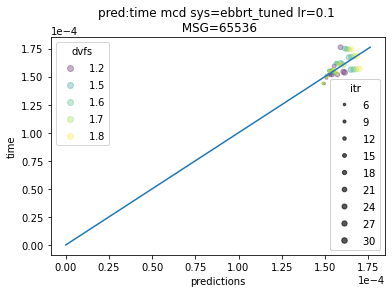

In [154]:
run(df_comb, n_iter=10000, lr=.1, rmsg=65536, mpred=['time'], msys=['ebbrt_tuned'])

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_energy=18.681472224736677 alpha=-0.0990293025970459 J


<ipython-input-30-0addb9a7217e>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-30-0addb9a7217e>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([680])) that is different to the input size (torch.Size([1, 680])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE_loss_energy=3.349001683366263e-07 alpha=5.4724056099075824e-05 J
MSE_loss_energy=3.3489944894610644e-07 alpha=5.466543007059954e-05 J
MSE_loss_energy=3.3489944894458e-07 alpha=5.466537913889624e-05 J
MSE_loss_energy=3.3489944894409114e-07 alpha=5.4665350035065785e-05 J
MSE_loss_energy=3.34899448943987e-07 alpha=5.466534275910817e-05 J
MSE_loss_energy=3.348994489439332e-07 alpha=5.466533184517175e-05 J
MSE_loss_energy=3.3489944894389087e-07 alpha=5.466532820719294e-05 J
MSE_loss_energy=1.0592082571550955e-06 alpha=2.1330277377273887e-05 J
MSE_loss_energy=3.440480151089373e-07 alpha=5.838388460688293e-05 J
MSE_loss_energy=3.349623944952624e-07 alpha=5.497341408045031e-05 J
MSE_loss_energy=7.164122409006158e-07 alpha=3.072250183322467e-05 J
MSE_loss_energy=4.36903829727795e-06 alpha=-2.3160711862146854e-05 J
MSE_loss_energy=3.348995113745342e-07 alpha=5.4675008868798614e-05 J
MSE_loss_energy=3.3489944900058766e-07 alpha=5.466504080686718e-05 J
MSE_loss_energy=3.349039223646735e-07 alp

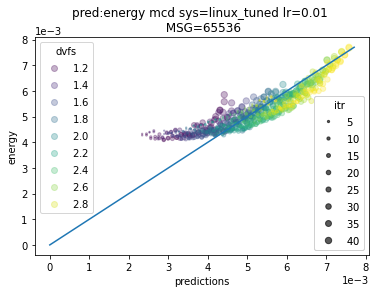

In [45]:
run_energy(df_comb, n_iter=30000, lr=.01, rmsg=65536, mpred=['energy'], msys=['linux_tuned'])


[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_time=2.607992334315835e-09 loss_time=51.06851 us


<ipython-input-57-930966d77645>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-57-930966d77645>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-57-930966d77645>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modu

MSE_loss_time=1.4321045374656487e-10 loss_time=11.96706 us
MSE_loss_time=1.1229138646877116e-10 loss_time=10.59676 us
MSE_loss_time=9.833010400099115e-11 loss_time=9.91615 us
MSE_loss_time=9.200676189518122e-11 loss_time=9.59202 us
MSE_loss_time=8.793716094145902e-11 loss_time=9.37748 us
MSE_loss_time=8.473511251011704e-11 loss_time=9.20517 us
MSE_loss_time=8.21104176869666e-11 loss_time=9.06148 us
MSE_loss_time=7.996481491071716e-11 loss_time=8.9423 us
MSE_loss_time=7.822415766882217e-11 loss_time=8.84444 us
MSE_loss_time=7.682671397251105e-11 loss_time=8.76508 us
MSE_loss_time=7.571198302318803e-11 loss_time=8.70126 us
MSE_loss_time=7.48307368101092e-11 loss_time=8.65048 us
MSE_loss_time=7.413629515511132e-11 loss_time=8.61024 us
MSE_loss_time=7.359265064749525e-11 loss_time=8.57862 us
MSE_loss_time=7.316875728823207e-11 loss_time=8.55387 us
MSE_loss_time=7.283833685100317e-11 loss_time=8.53454 us
MSE_loss_time=7.258367014843486e-11 loss_time=8.51961 us
MSE_loss_time=7.23863011322811

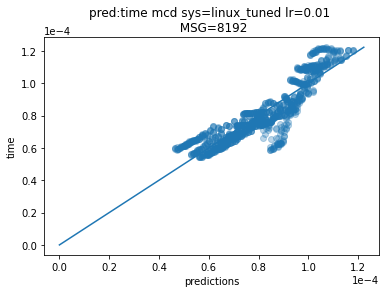

In [65]:
df_comb = pd.read_csv('/home/handong/jupyter/jupyter-notebooks/nic-tuning-experiments/bayesopt/summary_data/netpipe_combined.csv', sep=' ')
#df_comb = df_comb[(df_comb['i'] == 1) & (df_comb['rapl'] == 135)]
df_comb = df_comb[(df_comb['rapl'] == 135)]

df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: dvfs_dict[x])
df_comb = df_comb[(df_comb['itr']!=1) & (df_comb['dvfs']!=65535)] #filter out linux dynamic

run_energy(df_comb, n_iter=30000, lr=.01, rmsg=8192, mpred=['time'], msys=['linux_tuned'])

[ 6  8 10 12 14 16 20 24 28 30]
SYS ebbrt_tuned
loss_time=2.57520754163816e-06 max_time=-11.216626167297363 alpha=0.3909003734588623 gamma=0.9856512546539307 delta=0.5502802133560181


<ipython-input-14-718e03a868a5>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-14-718e03a868a5>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-14-718e03a868a5>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-14-718e03a868a5>:24: UserWarning: To copy construc

loss_time=4.969348230600252e-10 max_time=-11.678744316101074 alpha=0.705072283744812 gamma=0.5869538187980652 delta=0.15162181854248047
loss_time=3.1589909805032055e-10 max_time=-11.555351257324219 alpha=0.6717889904975891 gamma=0.5569562315940857 delta=0.1252904087305069
loss_time=2.596477904439758e-10 max_time=-11.356971740722656 alpha=0.6064764261245728 gamma=0.545141339302063 delta=0.11924216151237488
loss_time=1.9554310192149585e-10 max_time=-11.130919456481934 alpha=0.5296098589897156 gamma=0.5335561037063599 delta=0.11535559594631195
loss_time=1.3196472427766278e-10 max_time=-10.906689643859863 alpha=0.4496612846851349 gamma=0.5181466341018677 delta=0.10872402787208557
loss_time=8.627199477662976e-11 max_time=-10.721221923828125 alpha=0.37631598114967346 gamma=0.5000279545783997 delta=0.09867574274539948
loss_time=6.440469141453763e-11 max_time=-10.59963607788086 alpha=0.31640923023223877 gamma=0.483280211687088 delta=0.08744902908802032
loss_time=5.6820670550361005e-11 max_time

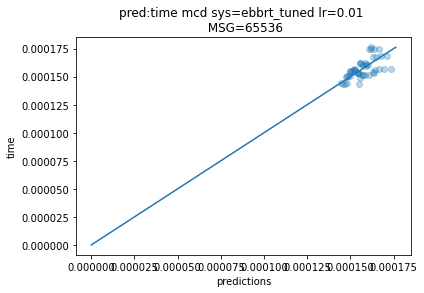

In [32]:
run_energy(df_comb, n_iter=20000, lr=0.01, rmsg=65536, mpred=['time'], msys=['ebbrt_tuned'])

[ 6  8 10 12 14 18 20 22 24 26 28 30 32 34 36 38 40 16]
SYS ebbrt_tuned
loss_time=1.3230961388258921e-08 max_time=-11.893648147583008 alpha=0.6270890235900879 gamma=0.18047595024108887 delta=-0.09962725639343262


<ipython-input-14-718e03a868a5>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-14-718e03a868a5>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-14-718e03a868a5>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-14-718e03a868a5>:24: UserWarning: To copy construc

loss_time=1.8958488275455196e-09 max_time=-11.03542423248291 alpha=0.3844453692436218 gamma=0.24624042212963104 delta=0.8157742619514465
loss_time=4.0103061025381426e-10 max_time=-9.965204238891602 alpha=0.015366299077868462 gamma=0.09874476492404938 delta=0.8807123303413391
loss_time=1.2521801763705126e-10 max_time=-9.682907104492188 alpha=-0.24912947416305542 gamma=0.09442934393882751 delta=0.7038712501525879
loss_time=8.856843543575778e-11 max_time=-9.702617645263672 alpha=-0.4068114459514618 gamma=0.1354701966047287 delta=0.6141543984413147
loss_time=6.996599469468223e-11 max_time=-9.724239349365234 alpha=-0.5223428010940552 gamma=0.16338804364204407 delta=0.55540931224823
loss_time=6.025628725733556e-11 max_time=-9.740906715393066 alpha=-0.6078701615333557 gamma=0.18102142214775085 delta=0.5154772996902466
loss_time=5.5122739095906116e-11 max_time=-9.75363540649414 alpha=-0.6712750792503357 gamma=0.19214054942131042 delta=0.4882328510284424
loss_time=5.2386910228608144e-11 max_tim

/home/handong/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


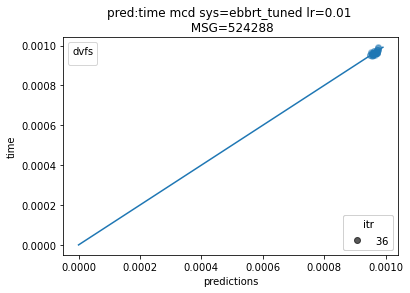

In [30]:
run_energy(df_comb, n_iter=10000, lr=0.01, rmsg=524288, mpred=['time'], msys=['ebbrt_tuned'])